In [174]:
#!pip install yfinance

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yfinance import download
from datetime import datetime
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import datetime as dt
import os

In [175]:
# Define the directory for datasets
dataset_dir = r"C:\Users\alanm\OneDrive\Documents\MADS\Capstone1\GitHub_Project"

# Create directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

# Define the date range
start_date = '2024-01-01'
end_date = '2024-12-31'

def fetch_and_save_stock_data(ticker):
    """
    Fetches stock data and saves it with the required column names
    """
    # Download data
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Reset index to get Date as a column
    data = data.reset_index()
    
    # Rename 'Date' to 'Price' for consistency with existing files
    data = data.rename(columns={'Date': 'Price'})
    
    # Reorder columns
    data = data[['Price', 'Close', 'High', 'Low', 'Open', 'Volume']]
    
    # Save in raw format
    filepath = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_data.csv")
    data.to_csv(filepath, index=False)
    return data


In [176]:
def clean_dataset(filepath):
    """
    Cleans a dataset to ensure proper format:
    - Rename Price to Date
    - Remove empty rows and row 2
    - Ensure proper data types
    """
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Rename 'Price' column to 'Date'
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Date'})
    
    # Remove row 2 and any empty rows
    df = df.dropna(how='all')  # Remove completely empty rows
    if len(df) > 2:  # Make sure we have enough rows
        df = pd.concat([df.iloc[:1], df.iloc[2:]]).reset_index(drop=True)
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # Drop any rows with NaN values after conversion
    df = df.dropna()
    
    # Ensure correct column order
    df = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
    
    return df

# Define tickers
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', '^GSPC', 'BTC-USD', 'GC=F']

# Step 1: Fetch and save all data
print("Step 1: Fetching and saving raw data...")
raw_data = {}
for ticker in tickers:
    print(f"Fetching data for {ticker}")
    try:
        raw_data[ticker] = fetch_and_save_stock_data(ticker)
        print(f"Successfully saved raw data for {ticker}")
    except Exception as e:
        print(f"Error fetching {ticker}: {str(e)}")

# Step 2: Clean all datasets
print("\nStep 2: Cleaning and saving processed data...")
cleaned_data = {}
for ticker in tickers:
    try:
        input_path = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_data.csv")
        print(f"Cleaning data for {ticker}")
        
        # Clean the dataset
        cleaned_data[ticker] = clean_dataset(input_path)
        
        # Save cleaned data
        output_path = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_cleaned.csv")
        cleaned_data[ticker].to_csv(output_path, index=False)
        
        # Verify the output
        print(f"Successfully cleaned and saved data for {ticker}")
        print(f"Number of rows: {len(cleaned_data[ticker])}")
        print("First few rows:")
        print(cleaned_data[ticker].head(3))
        print("\n")
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")

Step 1: Fetching and saving raw data...
Fetching data for META
Error fetching META: name 'yf' is not defined
Fetching data for AAPL
Error fetching AAPL: name 'yf' is not defined
Fetching data for AMZN
Error fetching AMZN: name 'yf' is not defined
Fetching data for NFLX
Error fetching NFLX: name 'yf' is not defined
Fetching data for GOOG
Error fetching GOOG: name 'yf' is not defined
Fetching data for ^GSPC
Error fetching ^GSPC: name 'yf' is not defined
Fetching data for BTC-USD
Error fetching BTC-USD: name 'yf' is not defined
Fetching data for GC=F
Error fetching GC=F: name 'yf' is not defined

Step 2: Cleaning and saving processed data...
Cleaning data for META
Successfully cleaned and saved data for META
Number of rows: 250
First few rows:
        Date       Close        High         Low        Open      Volume
1 2024-01-03  343.159149  346.625917  341.874050  343.667218  15451100.0
2 2024-01-04  345.799072  346.825152  342.093227  343.189047  12099900.0
3 2024-01-05  350.610687  352.

In [177]:
# Basic statistics
print(aapl.describe())

            Close        High         Low        Open        Volume
count  250.000000  250.000000  250.000000  250.000000  2.500000e+02
mean   206.683613  208.375219  204.693268  206.414183  5.709639e+07
std     25.631710   25.707030   25.250089   25.448453  3.089452e+07
min    164.405121  165.800067  163.488440  164.753864  2.323470e+07
25%    183.385326  184.447847  181.609617  182.922026  4.182658e+07
50%    213.782074  216.476519  211.467309  213.826981  4.986030e+07
75%    227.104362  229.044204  225.091735  227.150037  6.263040e+07
max    259.019989  260.100006  257.630005  258.190002  3.186799e+08


In [178]:
import pandas as pd
import os

# Define the directory for datasets
dataset_dir = r"C:\Users\alanm\OneDrive\Documents\MADS\Capstone1\GitHub_Project"

# Function to load cleaned data
def load_cleaned_data(ticker):
    """Load cleaned data from CSV and set Date as index"""
    file_path = os.path.join(dataset_dir, f"{ticker.replace('^', '').replace('=', '_')}_cleaned.csv")
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

# Define grouping function
def group_stocks(stock_dict):
    """Group stocks by their Close prices"""
    return pd.concat({key: stock["Close"] for key, stock in stock_dict.items()}, axis=1)

# Load all cleaned data
meta = load_cleaned_data('META')
aapl = load_cleaned_data('AAPL')
amzn = load_cleaned_data('AMZN')
nflx = load_cleaned_data('NFLX')
goog = load_cleaned_data('GOOG')
sp500 = load_cleaned_data('GSPC')
bitcoin = load_cleaned_data('BTC-USD')
gold = load_cleaned_data('GC=F')

# Create FAANG portfolio
faang = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
})

# Create FAANG + Gold portfolio
faang_gold = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold
})

# Create All Assets portfolio
all_assets = group_stocks({
    'Bitcoin': bitcoin,
    'S&P 500': sp500,
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
})

# Print information about each portfolio
print("\nFAANG Portfolio Shape:", faang.shape)
print("First few rows of FAANG portfolio:")
print(faang.head())

print("\nFAANG + Gold Portfolio Shape:", faang_gold.shape)
print("First few rows of FAANG + Gold portfolio:")
print(faang_gold.head())

print("\nAll Assets Portfolio Shape:", all_assets.shape)
print("First few rows of All Assets portfolio:")
print(all_assets.head())


FAANG Portfolio Shape: (250, 5)
First few rows of FAANG portfolio:
              Facebook       Apple      Amazon     Netflix      Google
Date                                                                  
2024-01-03  343.159149  183.351746  148.470001  470.260010  139.857483
2024-01-04  345.799072  181.023178  144.570007  474.670013  137.545776
2024-01-05  350.610687  180.296692  145.240005  474.059998  136.898117
2024-01-08  357.295166  184.655365  149.100006  485.029999  140.026855
2024-01-09  356.069794  184.237411  151.369995  482.089996  142.049606

FAANG + Gold Portfolio Shape: (250, 6)
First few rows of FAANG + Gold portfolio:
              Facebook       Apple      Amazon     Netflix      Google  \
Date                                                                     
2024-01-03  343.159149  183.351746  148.470001  470.260010  139.857483   
2024-01-04  345.799072  181.023178  144.570007  474.670013  137.545776   
2024-01-05  350.610687  180.296692  145.240005  474.05999

In [179]:
# Define file names for all datasets
file_names = {
    "Amazon": "AMZN_cleaned.csv",
    "Apple": "AAPL_cleaned.csv",
    "Bitcoin": "BTC-USD_cleaned.csv",
    "Facebook": "META_cleaned.csv",
    "Google": "GOOG_cleaned.csv",
    "Netflix": "NFLX_cleaned.csv",
    "S&P 500": "GSPC_cleaned.csv",
    "Gold": "GC_F_cleaned.csv"
}

In [144]:
# Example function for support and resistance visualization
def support_and_resistance(data, title='Support and Resistance Example'):
    plt.figure(figsize=(15, 7))
    plt.plot(data['Date'], data['Close'], label='Close Prices', color='blue')
    plt.axhline(y=data['Close'].max(), color='red', linestyle='--', label='Resistance Level')
    plt.axhline(y=data['Close'].min(), color='green', linestyle='--', label='Support Level')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example function for time series decomposition
def time_series_decomposition(ts, period=12):
    decomposition = seasonal_decompose(ts, model='additive', period=period)
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    plt.show()

In [180]:
def process_data(file_path):
    """
    Process each dataset and compute summary statistics
    """
    try:
        # Read data
        df = pd.read_csv(file_path)
        
        # Convert Date to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Clean column names
        df = df.rename(columns=lambda x: x.strip())
        
        # Compute summary statistics for the Close column
        stats = df['Close'].describe()
        
        # Round statistics to 2 decimal places
        stats = stats.round(2)
        
        return stats
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Process all datasets
print("Processing datasets...")
all_assets = {}
for name, file_name in file_names.items():
    file_path = os.path.join(dataset_dir, file_name)
    print(f"Processing {name}...")
    stats = process_data(file_path)
    if stats is not None:
        all_assets[name] = stats

# Create summary DataFrame
summary_df = pd.DataFrame(all_assets)

# Rename columns to more readable format
summary_df.rename(
    columns={
        "count": "Count",
        "mean": "Mean",
        "std": "Std Dev",
        "min": "Minimum",
        "25%": "25th Percentile",
        "50%": "Median",
        "75%": "75th Percentile",
        "max": "Maximum"
    },
    inplace=True
)

# Set index name
summary_df.index.name = "Asset"

# Display results
print("\nSummary Statistics for All Assets:")
print("=" * 80)
print(summary_df)

# Optional: Save to CSV
output_path = os.path.join(dataset_dir, "asset_summary_statistics.csv")
summary_df.to_csv(output_path)
print(f"\nSummary statistics saved to: {output_path}")

Processing datasets...
Processing Amazon...
Processing Apple...
Processing Bitcoin...
Processing Facebook...
Processing Google...
Processing Netflix...
Processing S&P 500...
Processing Gold...

Summary Statistics for All Assets:
       Amazon   Apple    Bitcoin  Facebook  Google  Netflix  S&P 500     Gold
Asset                                                                        
count  250.00  250.00     364.00    250.00  250.00   250.00   250.00   250.00
mean   184.63  206.68   65948.54    508.62  164.88   671.43  5429.16  2390.35
std     17.22   25.63   14607.73     61.67   15.45   109.05   365.86   223.28
min    144.57  164.41   39507.37    343.16  132.09   470.26  4688.68  1990.30
25%    175.39  183.39   59091.27    474.89  153.13   609.46  5139.61  2289.45
50%    183.43  213.78   64148.89    503.85  166.07   647.84  5435.44  2385.40
75%    189.65  227.10   69126.51    562.82  176.15   706.88  5717.34  2609.48
max    232.93  259.02  106140.60    632.17  198.16   936.56  6090.27 

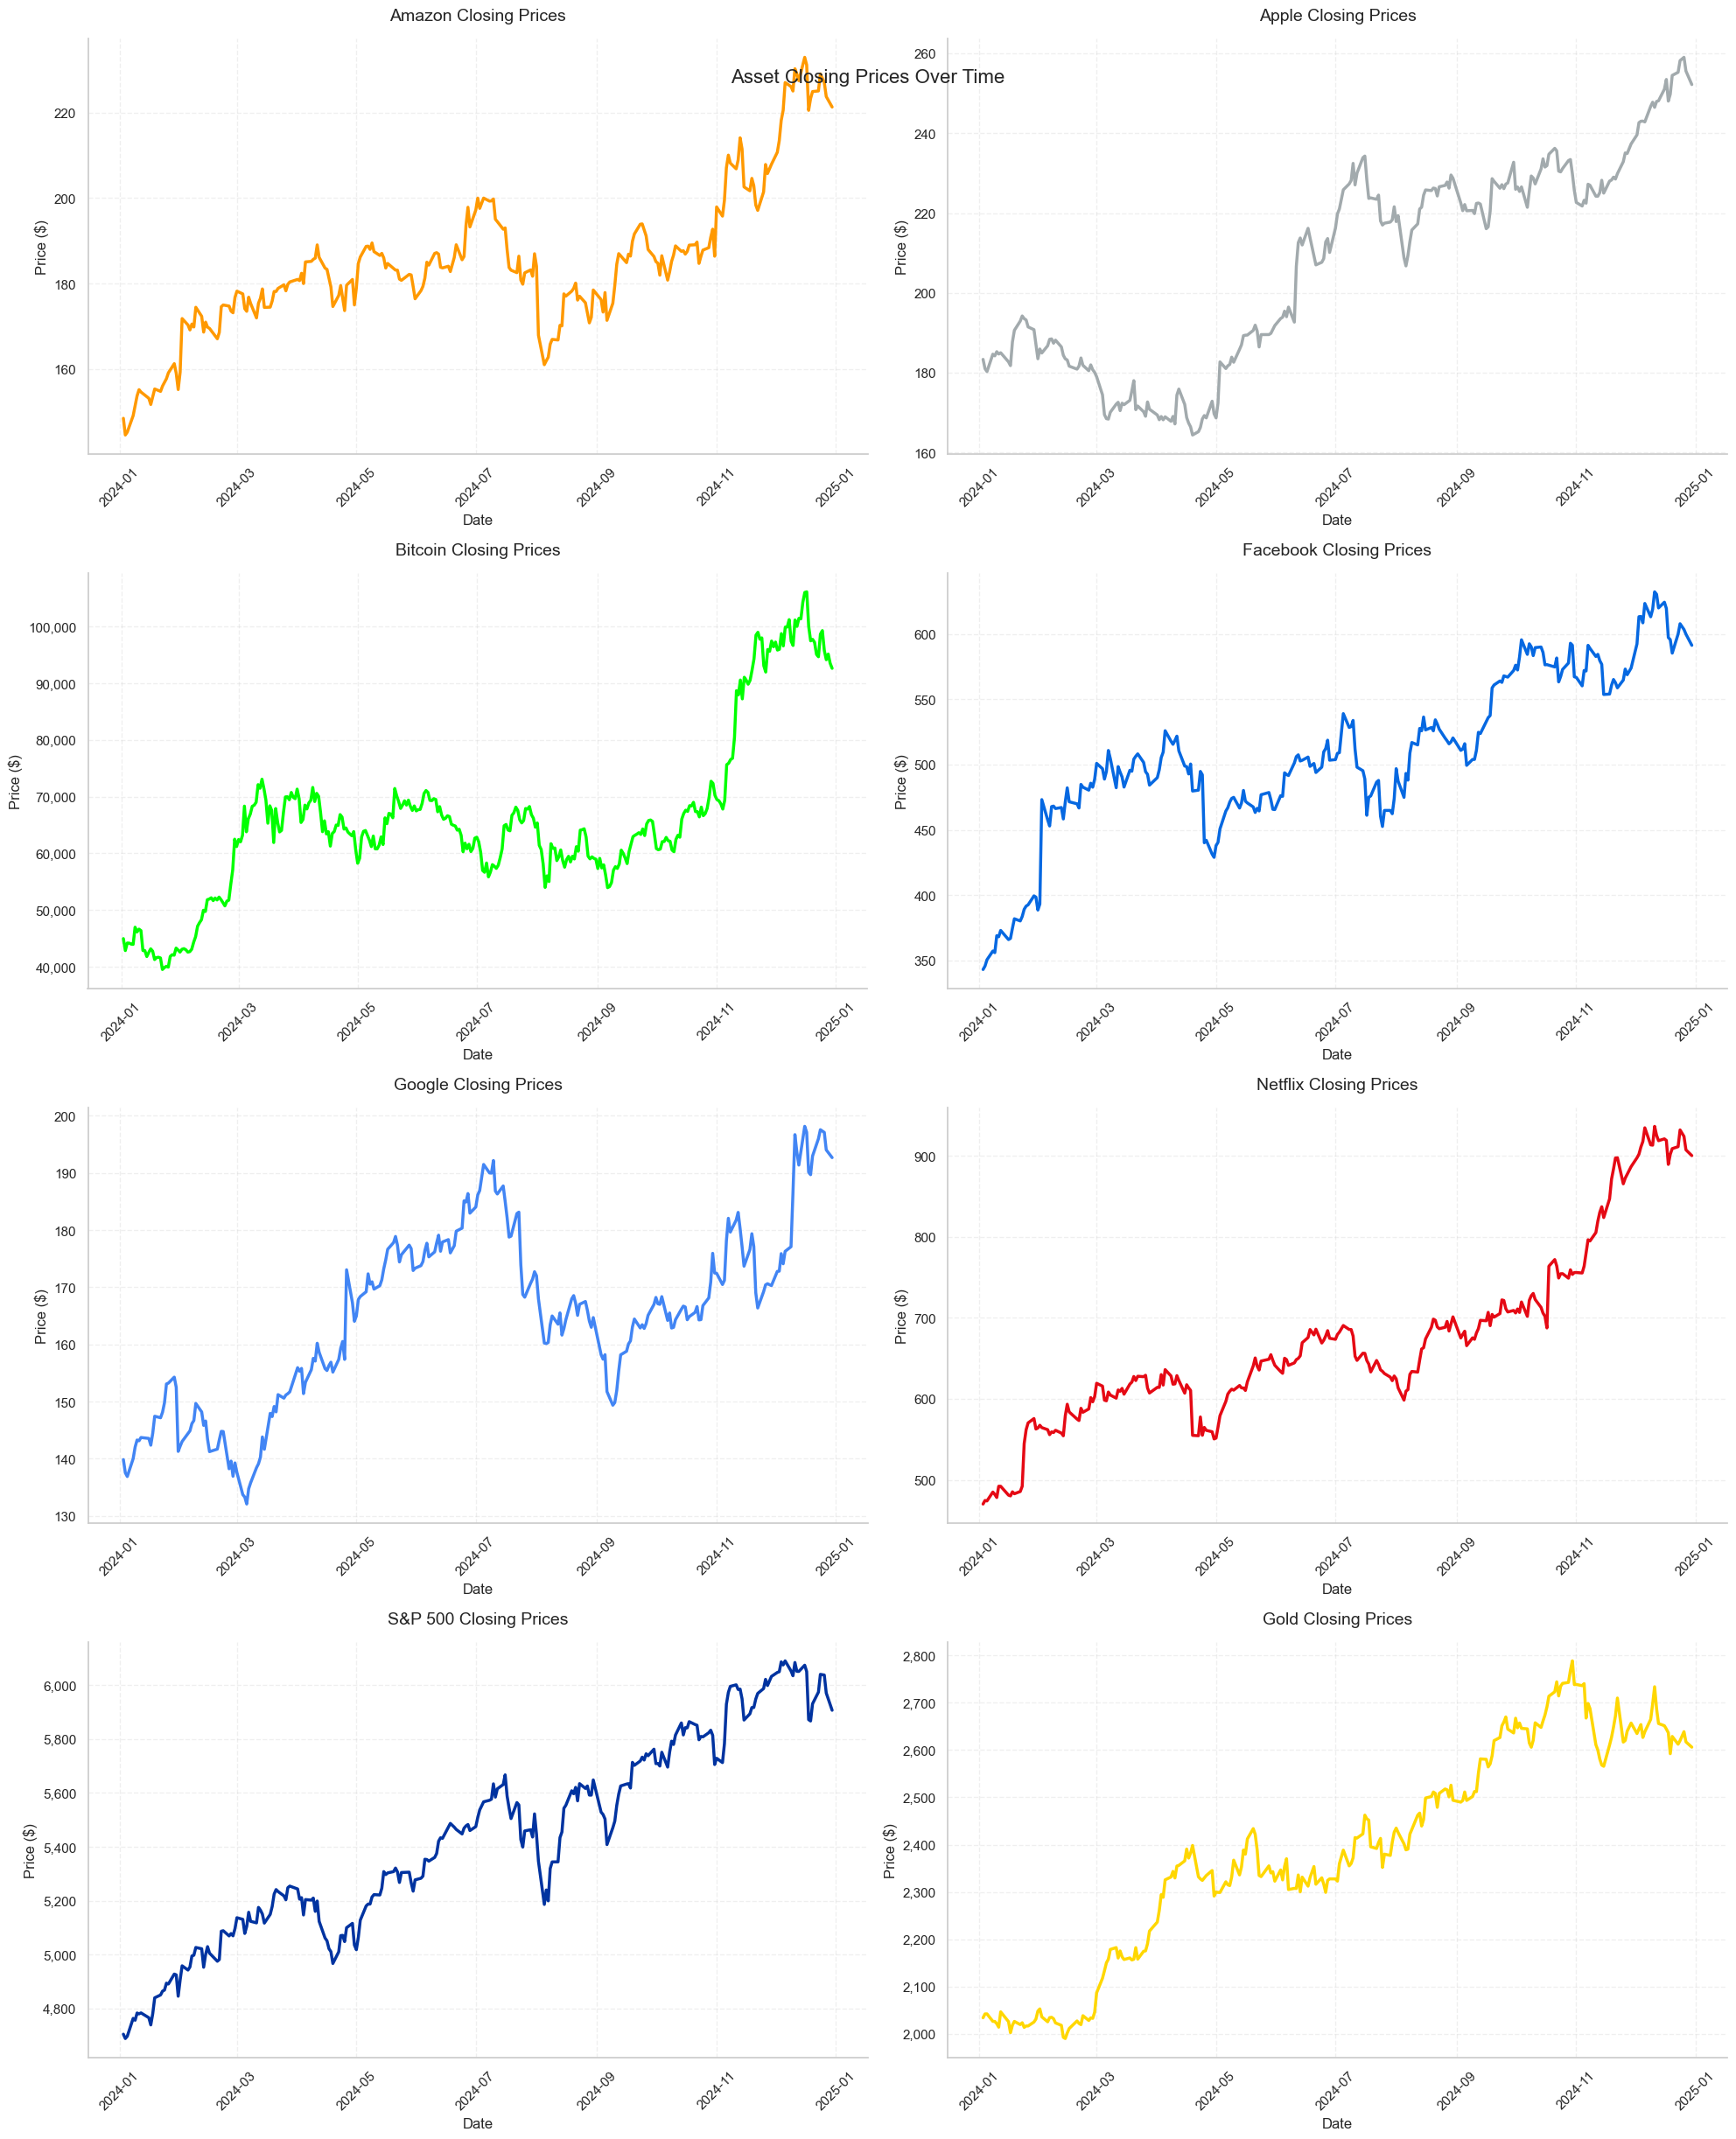

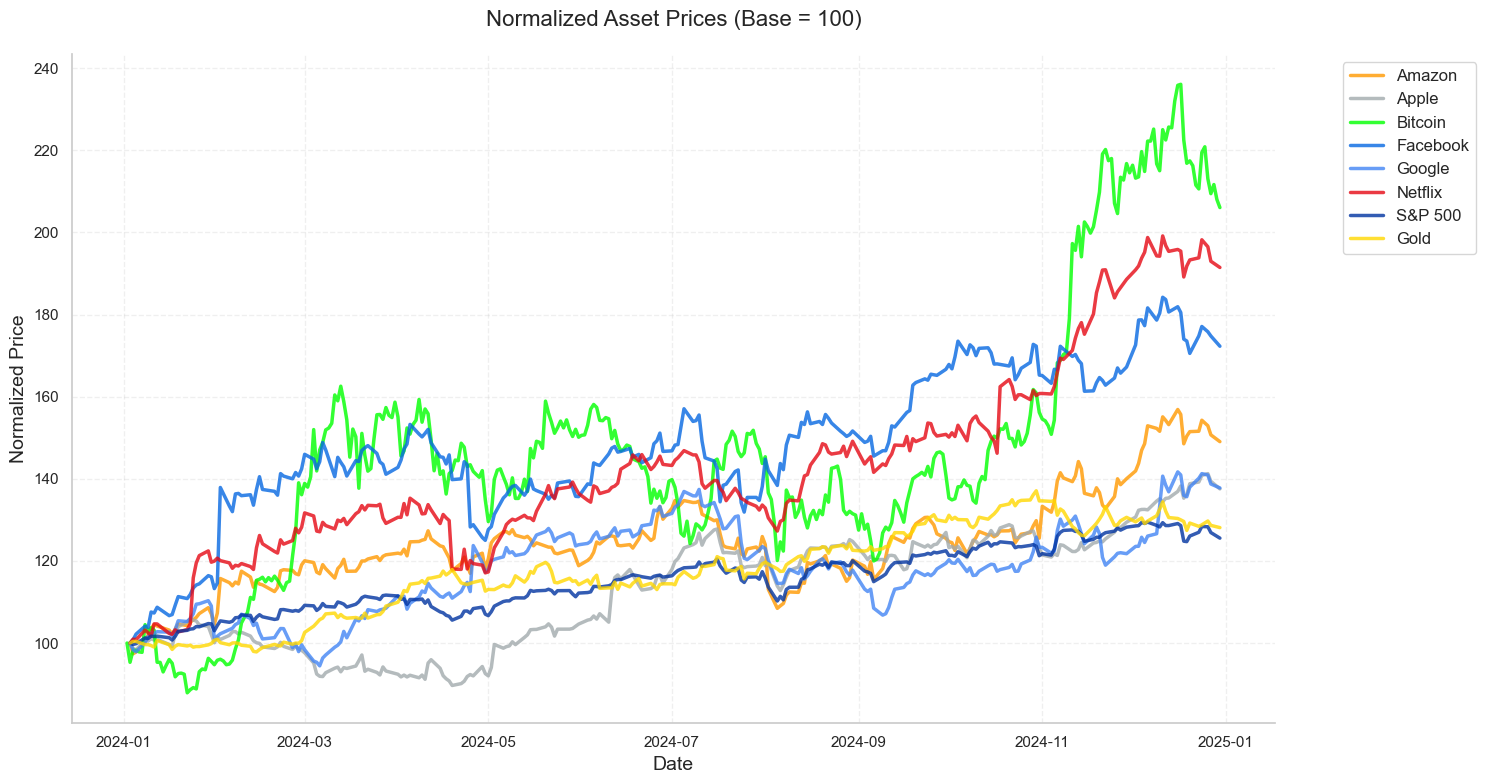

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the directory for datasets
dataset_dir = r"C:\Users\alanm\OneDrive\Documents\MADS\Capstone1\GitHub_Project"

# Define file names and colors for all datasets
file_names = {
    "Amazon": ("AMZN_cleaned.csv", "#FF9900"),    # Amazon orange
    "Apple": ("AAPL_cleaned.csv", "#A2AAAD"),     # Apple silver
    "Bitcoin": ("BTC-USD_cleaned.csv", "#00FF00"), # Bitcoin green
    "Facebook": ("META_cleaned.csv", "#0668E1"),   # Meta blue
    "Google": ("GOOG_cleaned.csv", "#4285F4"),     # Google blue
    "Netflix": ("NFLX_cleaned.csv", "#E50914"),    # Netflix red
    "S&P 500": ("GSPC_cleaned.csv", "#0033A0"),    # Dark blue
    "Gold": ("GC_F_cleaned.csv", "#FFD700")       # Gold
}

# Create subplots with improved style
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Asset Closing Prices Over Time', fontsize=16, y=0.95)

# Flatten axs for easier iteration
axs_flat = axs.flatten()

# Plot each dataset with enhanced styling
for idx, (name, (file_name, color)) in enumerate(file_names.items()):
    # Read data
    file_path = os.path.join(dataset_dir, file_name)
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create plot with enhanced styling
    sns.lineplot(data=df, x='Date', y='Close', color=color, ax=axs_flat[idx], 
                linewidth=2.5)
    
    # Customize plot with improved formatting
    axs_flat[idx].set_title(f'{name} Closing Prices', fontsize=14, pad=15)
    axs_flat[idx].set_xlabel('Date', fontsize=12)
    axs_flat[idx].set_ylabel('Price ($)', fontsize=12)
    axs_flat[idx].tick_params(axis='x', rotation=45)
    axs_flat[idx].grid(True, alpha=0.3, linestyle='--')
    
    # Format y-axis with comma separator and proper decimal handling
    axs_flat[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    
    # Set spines
    axs_flat[idx].spines['top'].set_visible(False)
    axs_flat[idx].spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the figure with high quality
plt.savefig(os.path.join(dataset_dir, 'all_assets_prices.png'), 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')

plt.show()

# Create a single normalized plot with enhanced styling
plt.figure(figsize=(15, 8))

# Plot normalized values with improved aesthetics
for name, (file_name, color) in file_names.items():
    file_path = os.path.join(dataset_dir, file_name)
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    normalized = df['Close'] / df['Close'].iloc[0] * 100
    
    plt.plot(df['Date'], normalized, label=name, linewidth=2.5, color=color, alpha=0.8)

plt.title('Normalized Asset Prices (Base = 100)', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized Price', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(rotation=0)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the normalized plot with high quality
plt.savefig(os.path.join(dataset_dir, 'normalized_prices.png'), 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')

plt.show()

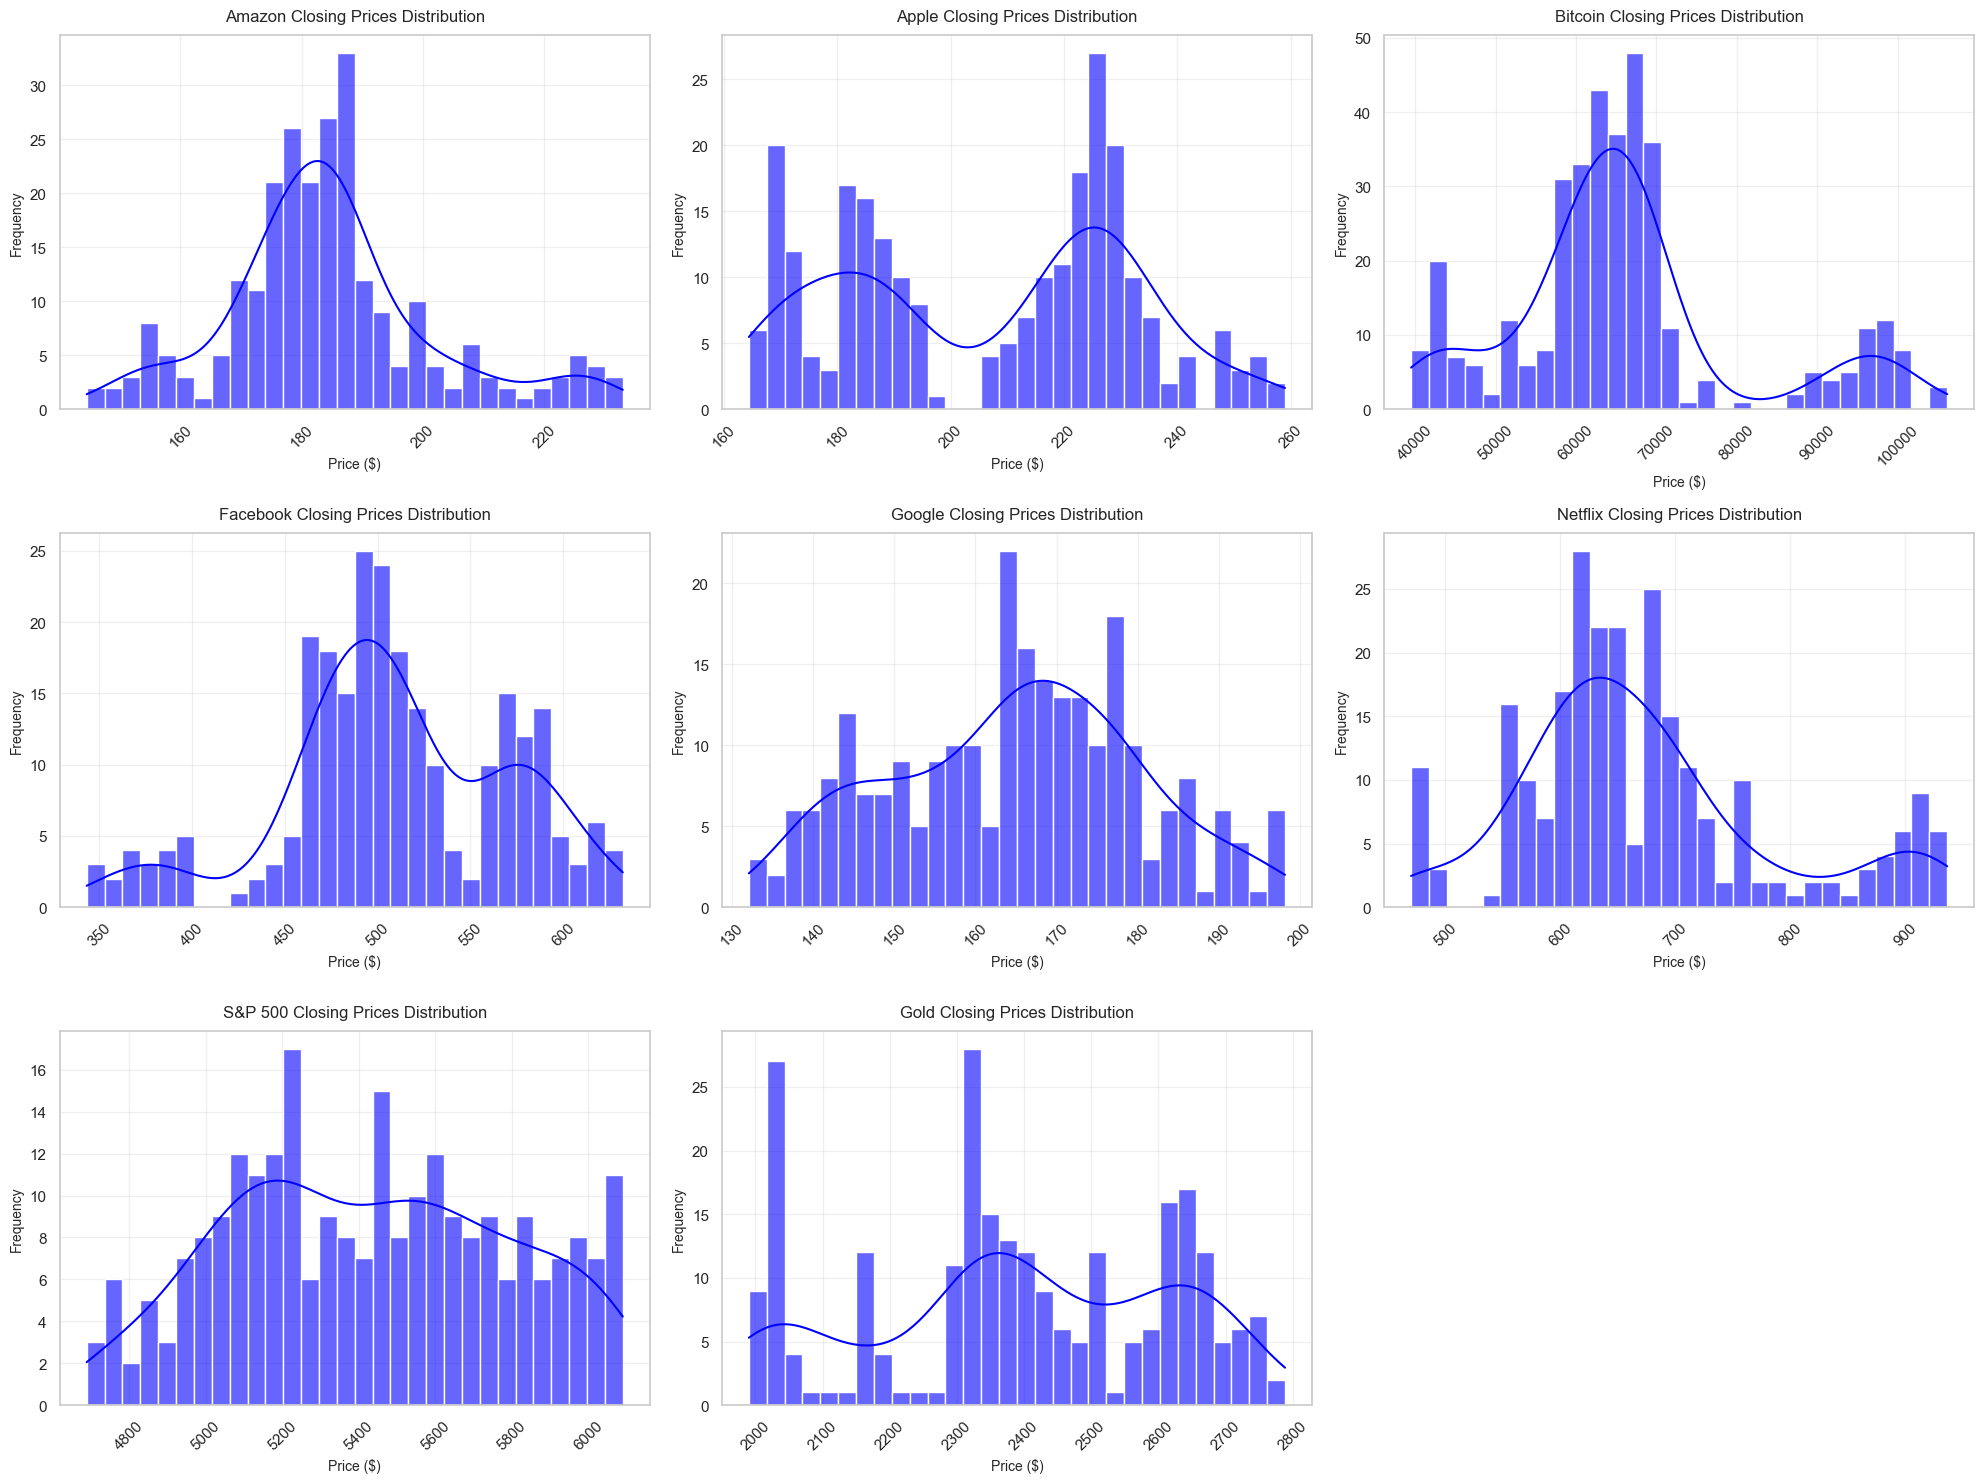

<Figure size 640x480 with 0 Axes>

In [170]:
# Load all closing prices into a dictionary
closing_prices = {}
for name, file_name in file_names.items():
    file_path = os.path.join(dataset_dir, file_name)
    df = pd.read_csv(file_path)
    closing_prices[name] = df['Close']

# Create histograms
plt.figure(figsize=(20, 15))

# Calculate number of rows and columns needed
n_stocks = len(closing_prices)
n_cols = 3
n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

# Create subplots for each stock
for i, (stock, prices) in enumerate(closing_prices.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Create histogram with KDE
    sns.histplot(data=prices.dropna(), 
                bins=30, 
                kde=True,
                color='blue',
                alpha=0.6)
    
    # Customize the subplot
    plt.title(f'{stock} Closing Prices Distribution', fontsize=12, pad=10)
    plt.xlabel('Price ($)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Optionally save the figure
plt.savefig(os.path.join(dataset_dir, 'closing_prices_distributions.png'), 
            dpi=300, 
            bbox_inches='tight')


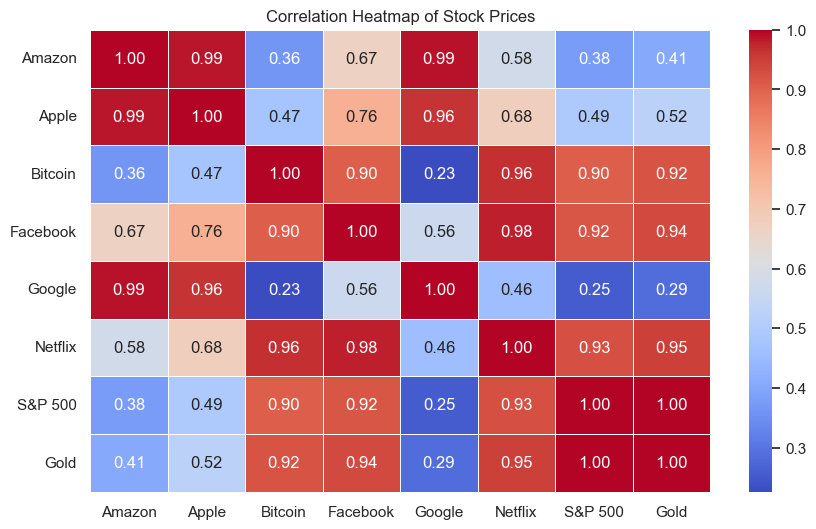

In [189]:
# Create a DataFrame with all assets' 'Close' prices
close_prices = pd.DataFrame(all_assets)

# Compute the correlation matrix
correlation_matrix = close_prices.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Stock Prices")
plt.show()

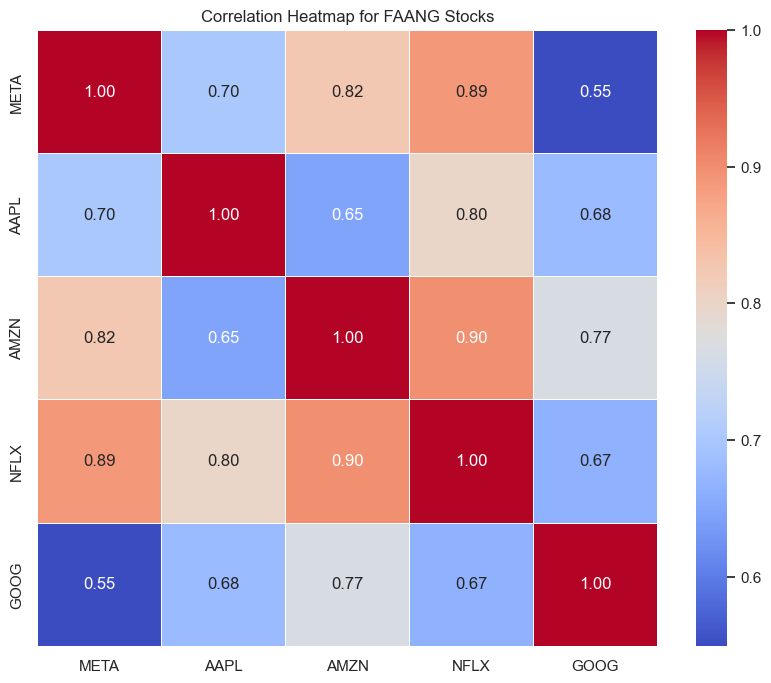

In [77]:
# Example correlation heatmap for FAANG stocks
faang.columns = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']  # Ensure correct column names
correlation_matrix = faang.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for FAANG Stocks")
plt.show()

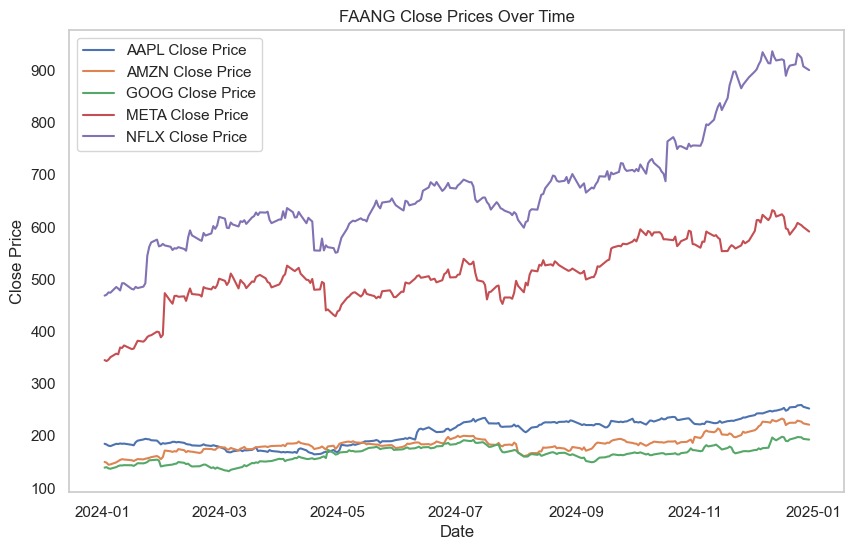

In [78]:
# Line plot for FAANG stock prices (Close)
plt.figure(figsize=(10, 6))
for name in ['AAPL', 'AMZN', 'GOOG', 'META', 'NFLX']:
    plt.plot(cleaned_data[name]['Date'], cleaned_data[name]['Close'], label=f'{name} Close Price')
plt.title('FAANG Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


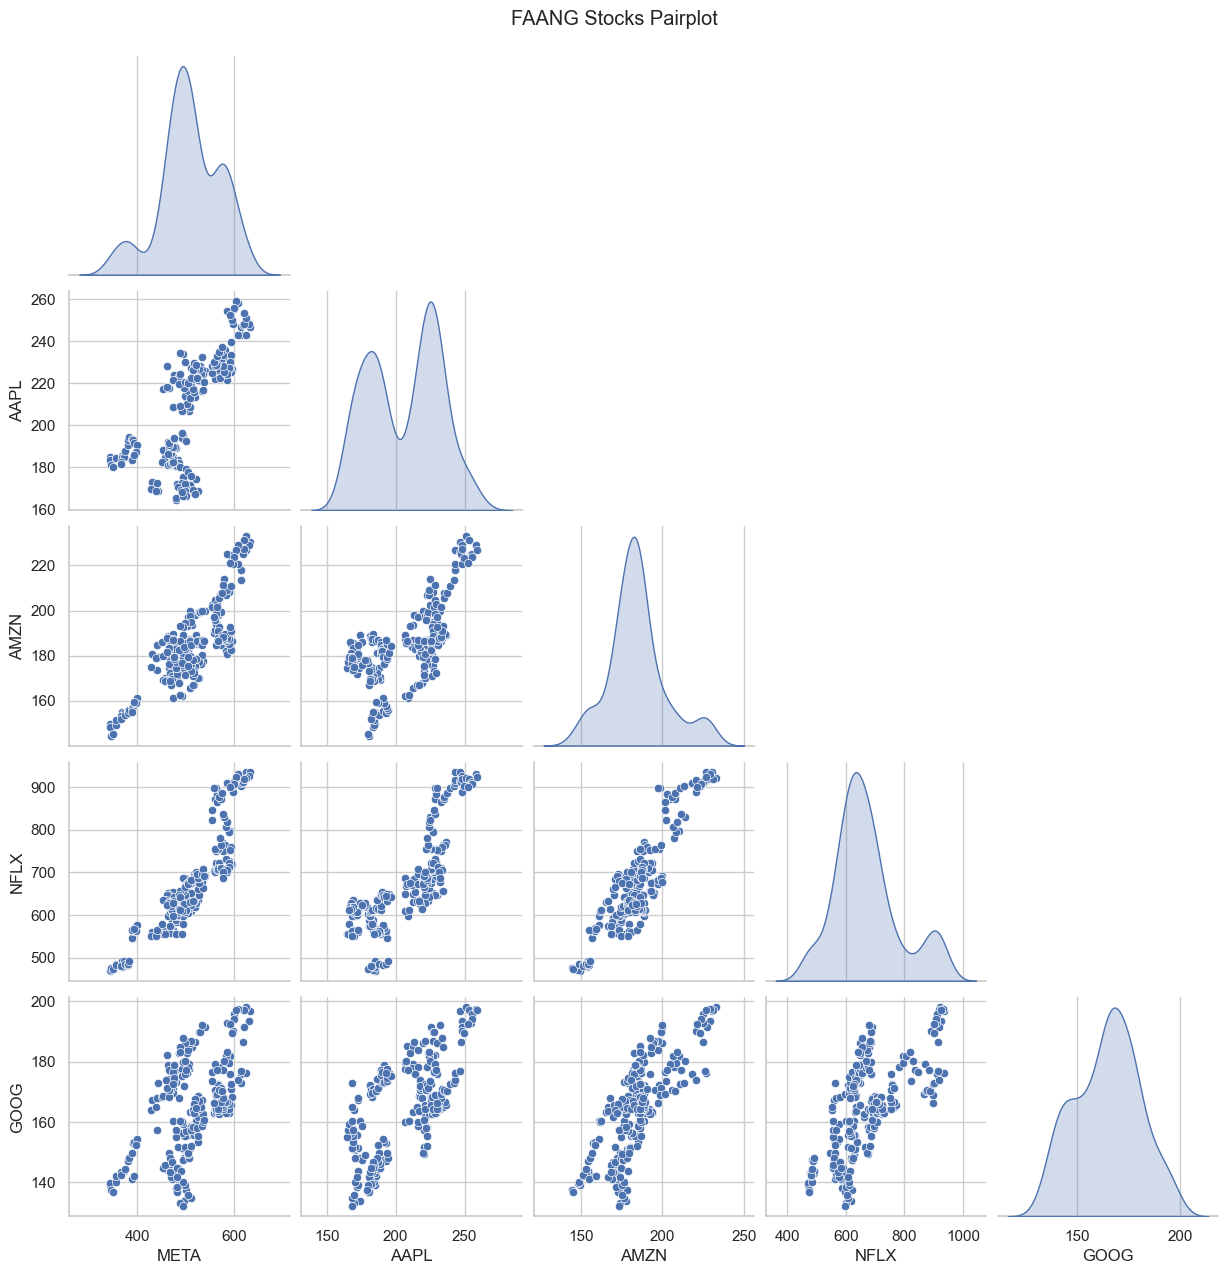

In [102]:
# Example pairplot for FAANG stocks
sns.set_theme(style="whitegrid")
faang_viz = faang.reset_index(drop=True)  # Reset index for visualization
sns.pairplot(faang_viz, diag_kind="kde", kind="scatter", corner=True)
plt.suptitle("FAANG Stocks Pairplot", y=1.02)
plt.show()


Comprehensive Asset Analysis:
          Annualized Volatility  Sharpe Ratio  Maximum Drawdown    Beta  \
Asset                                                                     
Amazon                   0.2818        1.3977           -0.1949  1.5392   
Apple                    0.2248        1.3253           -0.1535  0.9449   
Bitcoin                  0.4452        1.2361           -0.2618  1.4983   
Facebook                 0.3660        1.5464           -0.1843  1.5439   
Google                   0.2783        1.1248           -0.2228  1.2360   
Netflix                  0.2960        2.2007           -0.1345  1.1387   
S&P 500                  0.1267        1.4874           -0.0849  1.0000   
Gold                     0.1496        1.4174           -0.0799  0.1976   

          Mean Daily Return  Median Daily Return  Start Price   End Price  \
Asset                                                                       
Amazon               0.0018               0.0009     148.4700   

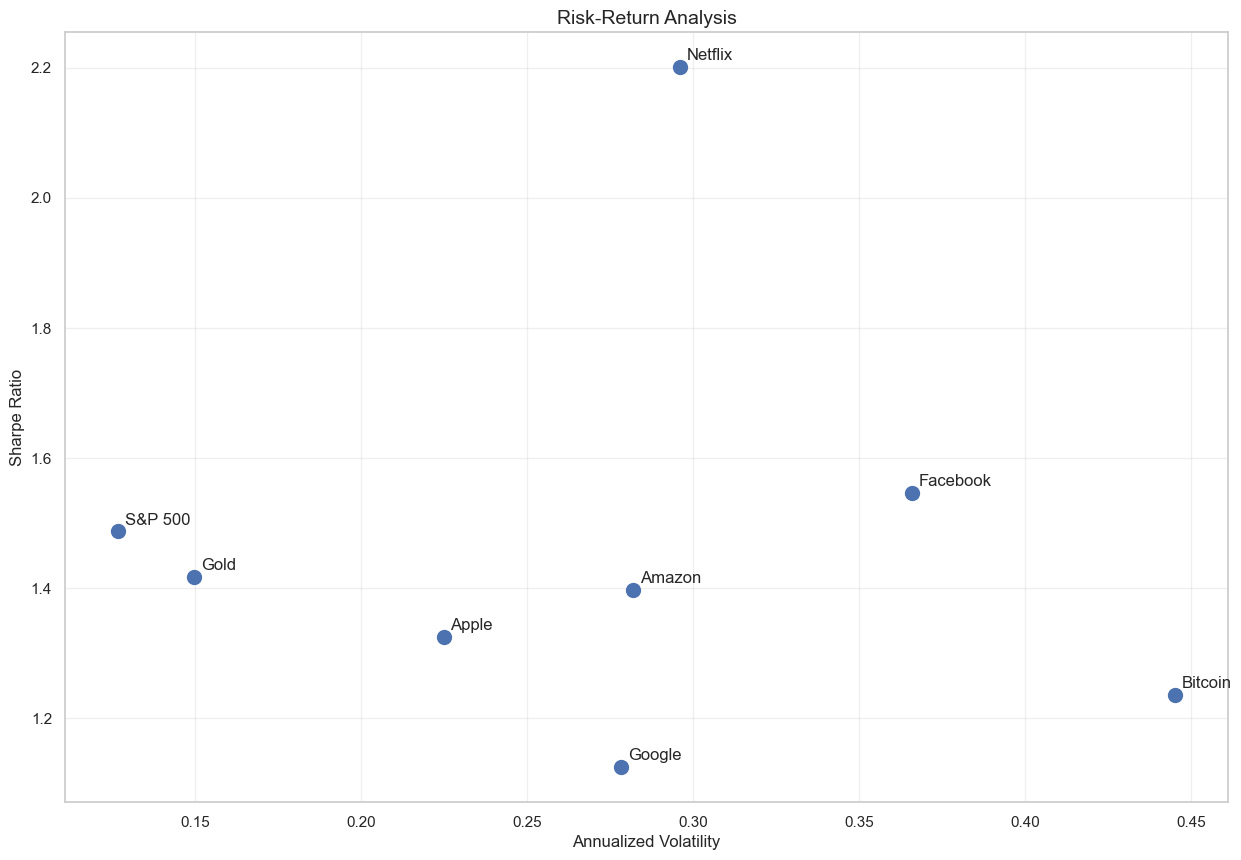


Key Findings:
--------------------------------------------------------------------------------
Highest Sharpe Ratio: Netflix (2.2007)
Lowest Volatility: S&P 500 (0.1267)
Highest Total Return: Bitcoin (106.07%)
Most Defensive (Lowest Beta): Gold (0.1976)


In [190]:
#Stock analysis_results

# Define the directory for datasets
dataset_dir = r"C:\Users\alanm\OneDrive\Documents\MADS\Capstone1\GitHub_Project"

class StockAnalyzer:
    def __init__(self, data, name):
        self.data = data
        self.name = name
    
    def annualized_volatility(self):
        """Calculate annualized volatility"""
        daily_returns = self.data['Close'].pct_change()
        return daily_returns.std() * np.sqrt(252)
    
    def daily_returns(self):
        """Calculate daily returns"""
        return self.data['Close'].pct_change()
    
    def sharpe_ratio(self, risk_free_rate=0.05):
        """Calculate Sharpe ratio with given risk-free rate"""
        daily_returns = self.daily_returns()
        excess_returns = daily_returns - risk_free_rate/252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    def max_drawdown(self):
        """Calculate maximum drawdown"""
        cumulative = (1 + self.daily_returns()).cumprod()
        rolling_max = cumulative.expanding(min_periods=1).max()
        drawdowns = cumulative/rolling_max - 1
        return drawdowns.min()
    
    def beta(self, market_data):
        """Calculate beta relative to the market (S&P 500)"""
        stock_returns = self.daily_returns()
        market_returns = market_data['Close'].pct_change()
        covariance = stock_returns.cov(market_returns)
        market_variance = market_returns.var()
        return covariance / market_variance
    
    def analyze(self, market_data):
        """Perform comprehensive analysis"""
        analysis = {
            'Asset': self.name,
            'Annualized Volatility': self.annualized_volatility(),
            'Sharpe Ratio': self.sharpe_ratio(),
            'Maximum Drawdown': self.max_drawdown(),
            'Beta': self.beta(market_data),
            'Mean Daily Return': self.daily_returns().mean(),
            'Median Daily Return': self.daily_returns().median(),
            'Start Price': self.data['Close'].iloc[0],
            'End Price': self.data['Close'].iloc[-1],
            'Total Return': (self.data['Close'].iloc[-1] / self.data['Close'].iloc[0] - 1)
        }
        return analysis

# Load all data
file_names = {
    "Amazon": "AMZN_cleaned.csv",
    "Apple": "AAPL_cleaned.csv",
    "Bitcoin": "BTC-USD_cleaned.csv",
    "Facebook": "META_cleaned.csv",
    "Google": "GOOG_cleaned.csv",
    "Netflix": "NFLX_cleaned.csv",
    "S&P 500": "GSPC_cleaned.csv",
    "Gold": "GC_F_cleaned.csv"
}

# Load and analyze all assets
assets_data = {}
market_data = None

# First load market data (S&P 500)
sp500_path = os.path.join(dataset_dir, file_names["S&P 500"])
market_data = pd.read_csv(sp500_path)
market_data['Date'] = pd.to_datetime(market_data['Date'])
market_data.set_index('Date', inplace=True)

# Load and analyze all other assets
analysis_results = []
for name, file_name in file_names.items():
    file_path = os.path.join(dataset_dir, file_name)
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    analyzer = StockAnalyzer(data, name)
    result = analyzer.analyze(market_data)
    analysis_results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(analysis_results)

# Format the results
results_df = results_df.set_index('Asset')
results_df = results_df.round(4)

# Print formatted results
print("\nComprehensive Asset Analysis:")
print("=" * 80)
print(results_df)

# Create visualization of key metrics
plt.figure(figsize=(15, 10))

# Plot volatility vs Sharpe ratio
plt.scatter(results_df['Annualized Volatility'], 
           results_df['Sharpe Ratio'], 
           s=100)

# Add labels for each point
for idx, row in results_df.iterrows():
    plt.annotate(idx, 
                (row['Annualized Volatility'], row['Sharpe Ratio']),
                xytext=(5, 5), 
                textcoords='offset points')

plt.title('Risk-Return Analysis', fontsize=14)
plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.grid(True, alpha=0.3)

# Save results
results_df.to_csv(os.path.join(dataset_dir, 'asset_analysis.csv'))
plt.savefig(os.path.join(dataset_dir, 'risk_return_analysis.png'), 
            dpi=300, 
            bbox_inches='tight')

plt.show()

# Print summary statistics
print("\nKey Findings:")
print("-" * 80)
print(f"Highest Sharpe Ratio: {results_df['Sharpe Ratio'].idxmax()} ({results_df['Sharpe Ratio'].max():.4f})")
print(f"Lowest Volatility: {results_df['Annualized Volatility'].idxmin()} ({results_df['Annualized Volatility'].min():.4f})")
print(f"Highest Total Return: {results_df['Total Return'].idxmax()} ({results_df['Total Return'].max():.2%})")
print(f"Most Defensive (Lowest Beta): {results_df['Beta'].idxmin()} ({results_df['Beta'].min():.4f})")


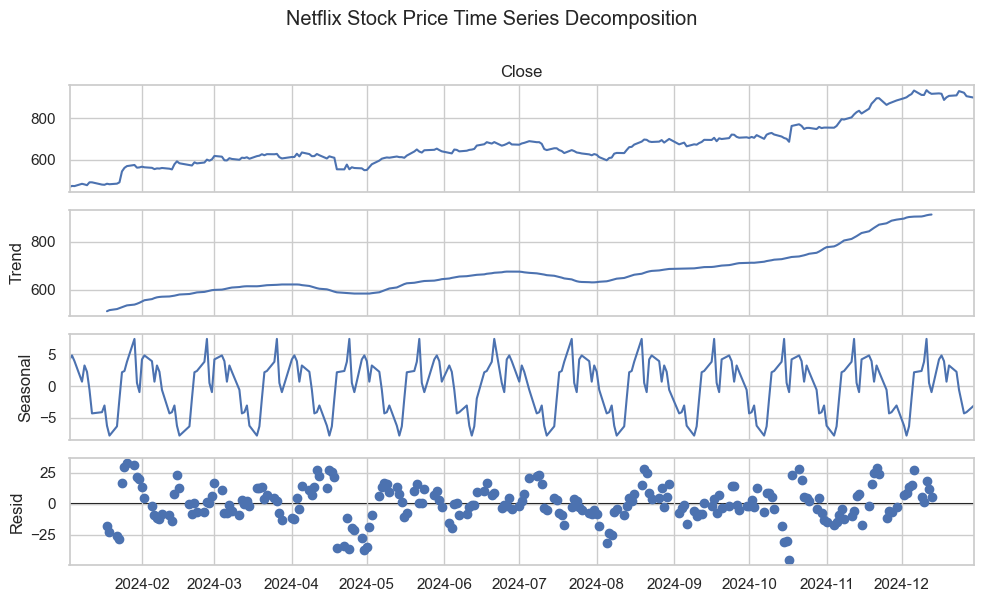

In [191]:
class StockModeler:
	@staticmethod
	def decompose(data, period):
		return sm.tsa.seasonal_decompose(data['Close'], period=period)

# Perform decomposition
decomposition = StockModeler.decompose(nflx, 20) # 20 period frequency
fig = decomposition.plot()
fig.suptitle('Netflix Stock Price Time Series Decomposition', y=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

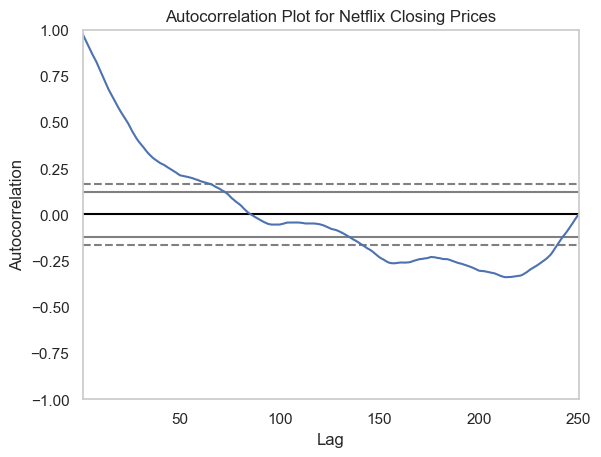

In [192]:
# Use the 'Close' column for the autocorrelation plot
from pandas.plotting import autocorrelation_plot

if 'Close' in nflx.columns:
    autocorrelation_plot(nflx['Close'])
    plt.title("Autocorrelation Plot for Netflix Closing Prices")
    plt.show()
else:
    print("The 'Close' column is not available in the Netflix DataFrame.")


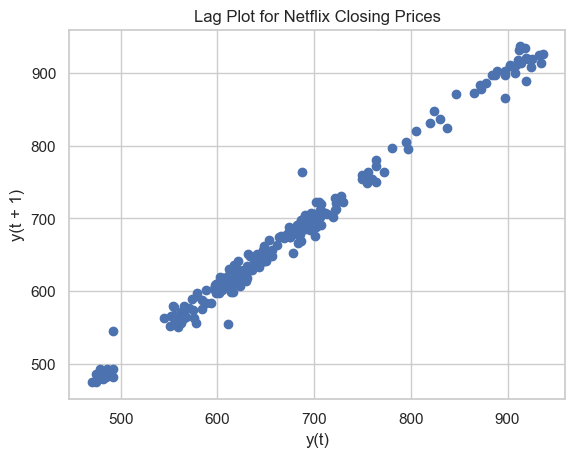

In [193]:
# Lag plot for Netflix stock
data_to_plot = nflx['Close'] if 'Close' in nflx.columns else None
if data_to_plot is not None:
    lag_plot(data_to_plot)
    plt.title("Lag Plot for Netflix Closing Prices")
    plt.show()
else:
    print("The 'Close' column is not available for Netflix data.")

c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  250
Model:                ARIMA(10, 1, 5)   Log Likelihood                -971.943
Date:                Sat, 11 Jan 2025   AIC                           1975.886
Time:                        02:16:58   BIC                           2032.165
Sample:                             0   HQIC                          1998.539
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4978      0.617     -0.807      0.420      -1.707       0.711
ar.L2          0.0636      0.340      0.187      0.851      -0.602       0.729
ar.L3         -0.1912      0.292     -0.655      0.5

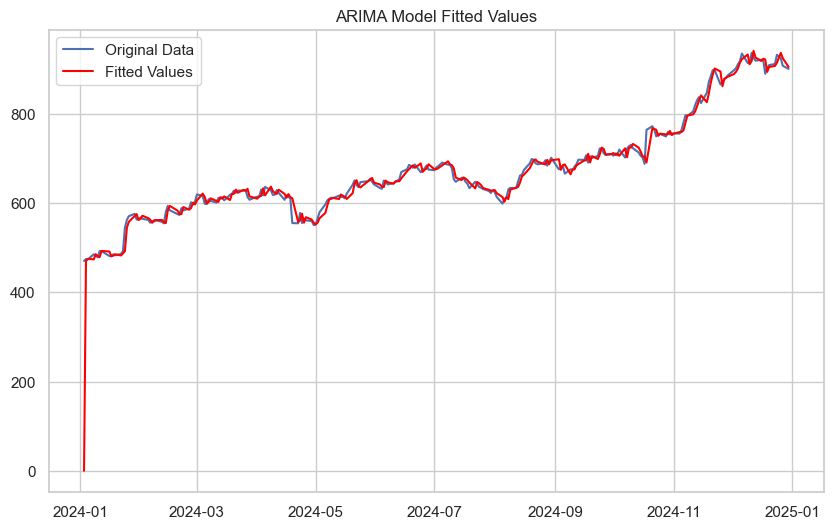

In [194]:
# Prepare the Netflix data for ARIMA modeling
if 'Close' in nflx.columns:
    nflx_close = nflx['Close'].dropna()  # Ensure no missing values
else:
    raise KeyError("The 'Close' column is not available in the Netflix data.")

# Define ARIMA parameters
ar_order = 10  # Autoregressive term
i_order = 1    # Differencing term
ma_order = 5   # Moving average term

# Fit the ARIMA model
arima_model = ARIMA(nflx_close, order=(ar_order, i_order, ma_order))
arima_result = arima_model.fit()

# Display the ARIMA model summary
print(arima_result.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(nflx_close, label="Original Data")
plt.plot(arima_result.fittedvalues, label="Fitted Values", color="red")
plt.title("ARIMA Model Fitted Values")
plt.legend()
plt.show()


In [195]:
# Perform linear regression analysis for Netflix
if 'Close' in nflx.columns and 'Volume' in nflx.columns:
    X = sm.add_constant(nflx['Volume'])  # Independent variable (add constant for intercept)
    Y = nflx['Close']  # Dependent variable
    lm = OLS(Y, X).fit()
    print(lm.summary())
else:
    print("Regression analysis requires both 'Close' and 'Volume' columns in the Netflix data.")


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.92
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           0.000237
Time:                        02:17:15   Log-Likelihood:                -1520.3
No. Observations:                 250   AIC:                             3045.
Df Residuals:                     248   BIC:                             3052.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        707.7578     11.833     59.812      0.0

c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


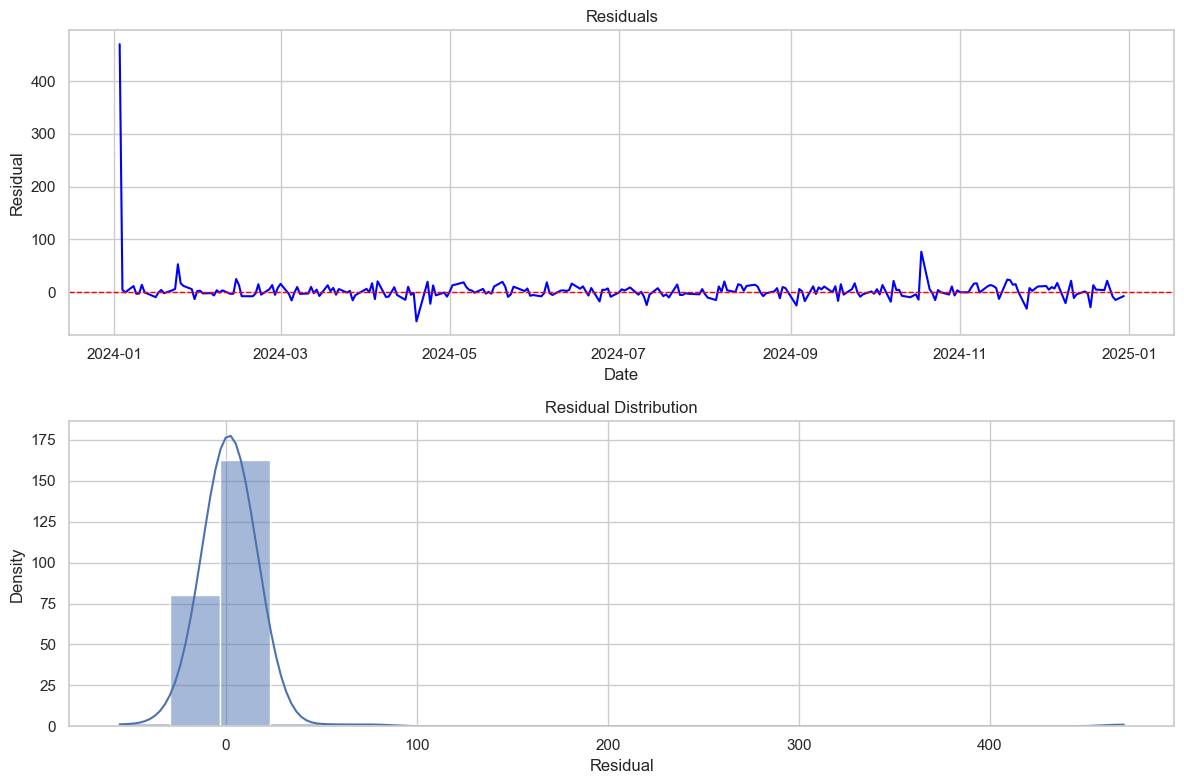

In [196]:
def fit_arima_model(data, order):
    """
    Fits an ARIMA model to the given data.
    
    Parameters:
    data (Series): Time series data to fit the model.
    order (tuple): The (p, d, q) order of the ARIMA model.
    
    Returns:
    ARIMAResults: The fitted ARIMA model results.
    """
    model = ARIMA(data, order=order)
    return model.fit()

def plot_residuals(residuals):
    """
    Plots the residuals and residual distribution from a time series model.
    
    Parameters:
    residuals (Series): Residuals from the time series model.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(residuals, color='blue')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_title('Residuals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Residual')
    
    sns.histplot(residuals, kde=True, bins=20, ax=ax2)
    ax2.set_title('Residual Distribution')
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Define ARIMA order
arima_order = (5, 1, 0)  # (p, d, q) order

# Fit ARIMA model and plot residuals
arima_results = fit_arima_model(nflx['Close'], order=arima_order)
plot_residuals(arima_results.resid)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3979315811.py:60: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)
C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3979315811.py:74: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset 

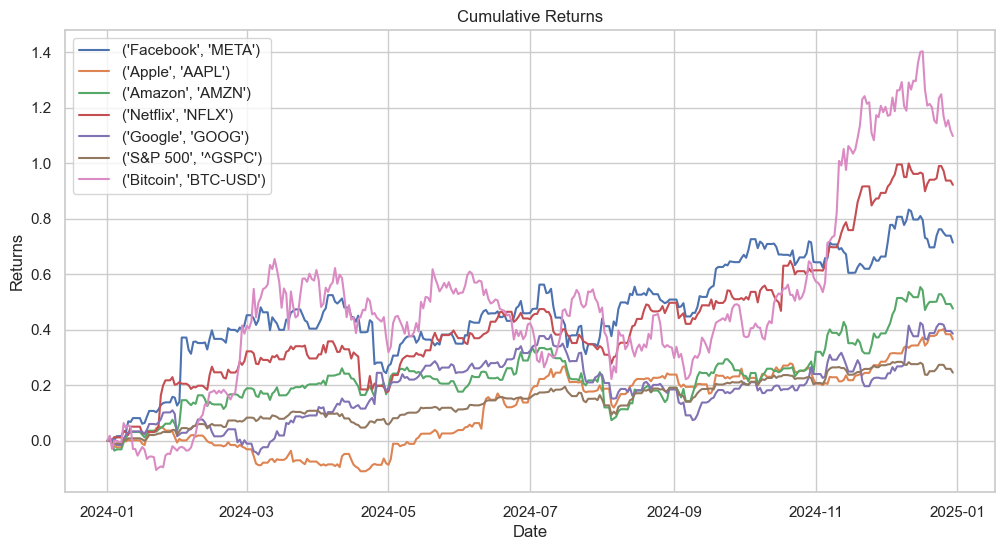

C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3979315811.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()


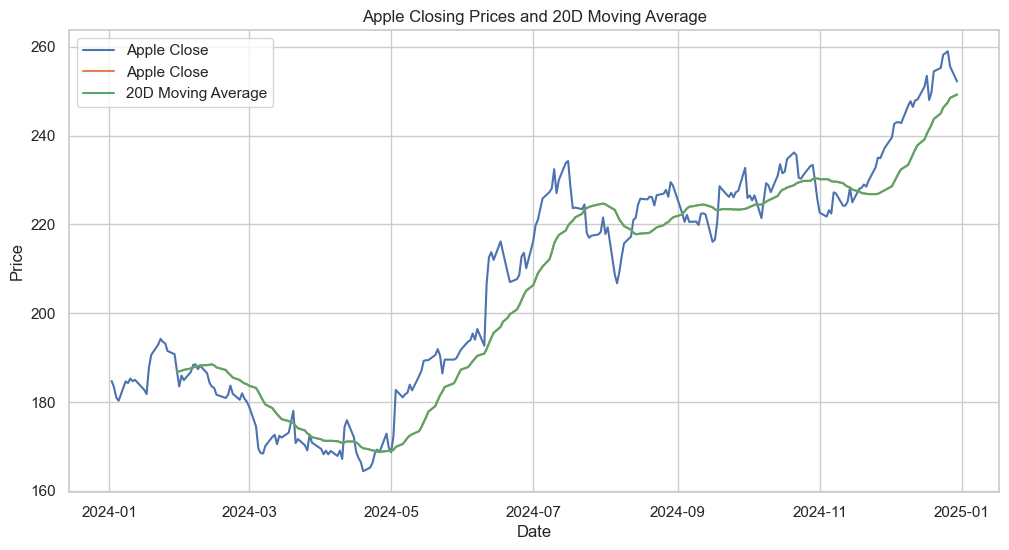

In [ ]:
# Define the date range for fetching data
start_date = '2024-01-01'
end_date = '2024-12-31'

# Fetch data using yfinance
def fetch_stock_data(ticker):
    """
    Fetches historical stock data for a given ticker symbol using yfinance.
    Returns a DataFrame with the fetched data.
    """
    return download(ticker, start=start_date, end=end_date)

# Get FAANG and market data
fb_data = fetch_stock_data('META') 
aapl_data = fetch_stock_data('AAPL')
amzn_data = fetch_stock_data('AMZN') 
nflx_data = fetch_stock_data('NFLX')
goog_data = fetch_stock_data('GOOG')
sp500_data = fetch_stock_data('^GSPC') 
bitcoin_data = fetch_stock_data('BTC-USD')

# Group stocks into DataFrames
def group_stocks(stock_dict):
    """
    Groups stock data from a dictionary into a single DataFrame.
    The resulting DataFrame has stock tickers as column names and closing prices as values.
    """
    return pd.concat({key: stock['Close'] for key, stock in stock_dict.items()}, axis=1)

faang_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data, 
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data
})

faang_sp500_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data,
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data,
    'S&P 500': sp500_data
})

all_assets_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data,
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data, 
    'S&P 500': sp500_data,
    'Bitcoin': bitcoin_data
})

# Functions for calculating returns
def calculate_returns(data):
    """Calculates daily returns."""
    return data.pct_change().fillna(0)

def calculate_cumulative_returns(data):
    """Calculates cumulative returns."""
    returns = calculate_returns(data)
    return (1 + returns).cumprod() - 1

# Plotting
def plot_cumulative_returns(data):
    """Plots cumulative returns for the given data."""
    cumulative_returns = calculate_cumulative_returns(data)
    
    plt.figure(figsize=(12, 6))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns[col], label=col)
    
    plt.title("Cumulative Returns")
    plt.xlabel("Date") 
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

def plot_moving_averages(data, ticker, window=20):
    """Plots closing prices and moving average for a given stock ticker."""
    stock_data = data[ticker]
    stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data, label=f'{ticker} Close')
    plt.plot(stock_data[f'{window}D_MA'], label=f'{window}D Moving Average')
    plt.title(f"{ticker} Closing Prices and {window}D Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Example usage
plot_cumulative_returns(all_assets_data)
plot_moving_averages(faang_data, 'Apple')


C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3450521654.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)


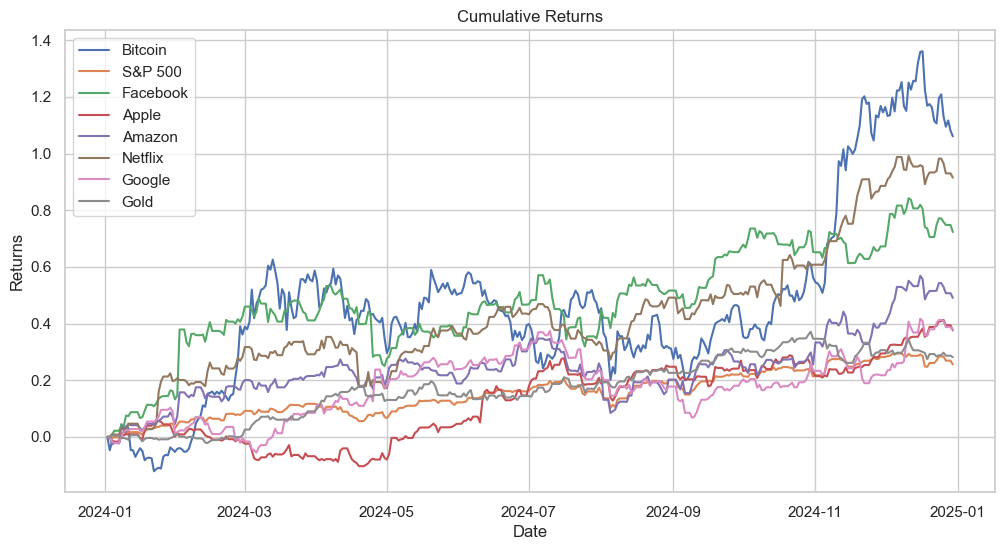

C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3450521654.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)


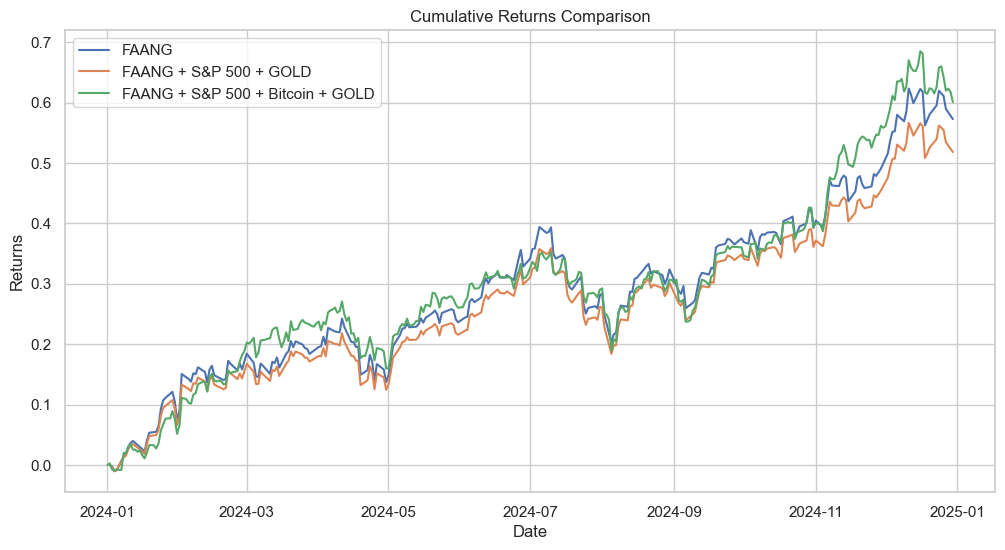

C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3450521654.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()


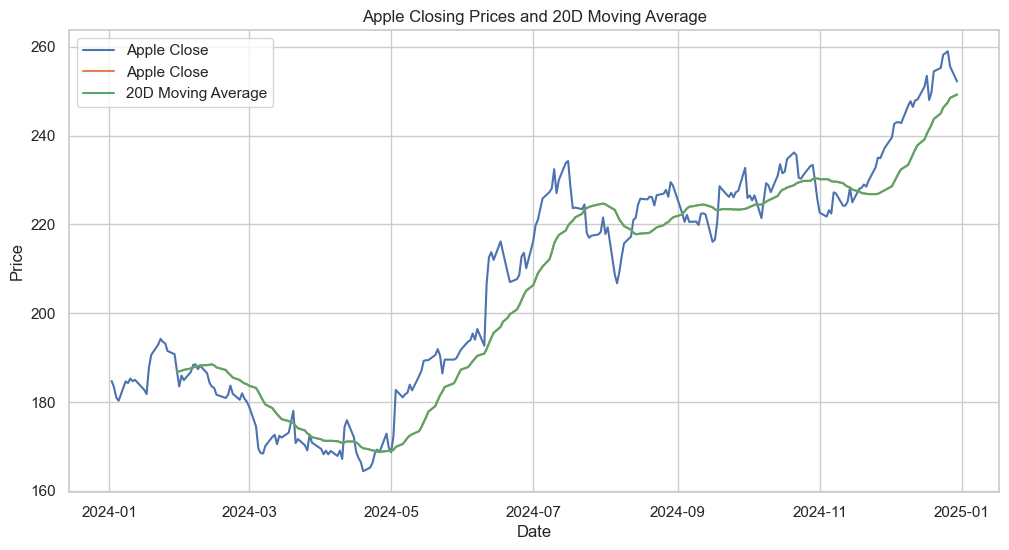

In [201]:
# Group stocks into DataFrames
def group_stocks(stock_dict):
    """
    Groups stock data from a dictionary into a single DataFrame.
    The resulting DataFrame has stock tickers as column names and closing prices as values.
    """
    return pd.concat({key: stock['Close'] for key, stock in stock_dict.items()}, axis=1)

# Create FAANG portfolio
faang = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
})

# Create FAANG + Gold portfolio
faang_gold = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold
})

# Create All Assets portfolio
all_assets = group_stocks({
    'Bitcoin': bitcoin,
    'S&P 500': sp500,
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold
})

# Functions for calculating returns
def calculate_returns(data):
    """Calculates daily returns."""
    return data.pct_change().fillna(0)

def calculate_cumulative_returns(data):
    """Calculates cumulative returns."""
    returns = calculate_returns(data)
    return (1 + returns).cumprod() - 1

# Plotting
def plot_cumulative_returns(data):
    """Plots cumulative returns for the given data."""
    cumulative_returns = calculate_cumulative_returns(all_assets)
    
    plt.figure(figsize=(12, 6))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns[col], label=col)
    
    plt.title("Cumulative Returns")
    plt.xlabel("Date") 
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

def plot_grouped_cumulative_returns(*datasets, labels):
    """Plots cumulative returns for grouped datasets."""
    plt.figure(figsize=(12, 6))
    for data, label in zip(datasets, labels):
        cumulative_returns = calculate_cumulative_returns(data).mean(axis=1)
        plt.plot(cumulative_returns, label=label)
    
    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

def plot_moving_averages(data, ticker, window=20):
    """Plots closing prices and moving average for a given stock ticker."""
    stock_data = data[ticker]
    stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data, label=f'{ticker} Close')
    plt.plot(stock_data[f'{window}D_MA'], label=f'{window}D Moving Average')
    plt.title(f"{ticker} Closing Prices and {window}D Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Example usage
plot_cumulative_returns(all_assets_data)

# Compare cumulative returns across groups
plot_grouped_cumulative_returns(faang_data, faang_sp500_data, all_assets_data, 
                                 labels=["FAANG", "FAANG + S&P 500 + GOLD", "FAANG + S&P 500 + Bitcoin + GOLD"])

plot_moving_averages(faang_data, 'Apple')

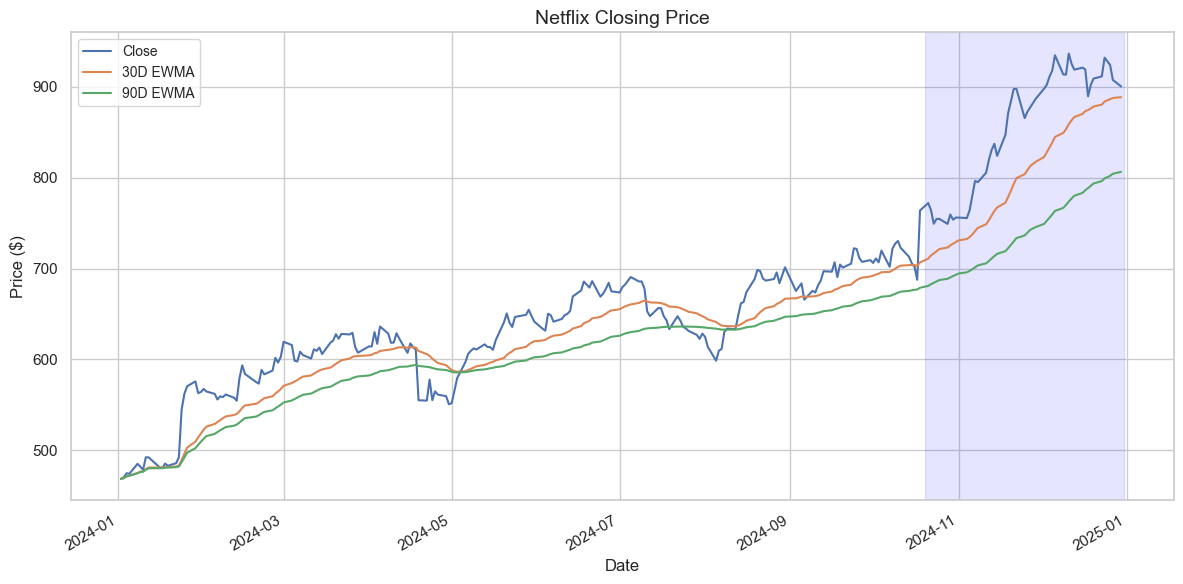

In [ ]:
# Exponential moving average

file_path = r'C:\Users\alanm\OneDrive\Documents\MADS\Capstone1\GitHub_Project\NFLX_data.csv'

# Reload the dataset with appropriate adjustments to align headers
nflx_data_corrected = pd.read_csv(file_path, skiprows=2)

# Rename columns for better clarity
nflx_data_corrected.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Drop rows where 'Date' is invalid (e.g., metadata rows)
nflx_data_corrected = nflx_data_corrected[~nflx_data_corrected['Date'].str.contains('Date', na=False)]

# Convert 'Date' to datetime and set it as the index
nflx_data_corrected['Date'] = pd.to_datetime(nflx_data_corrected['Date'])
nflx_data_corrected.set_index('Date', inplace=True)

# Convert numeric columns to the correct data type
nflx_data_corrected[['Close', 'High', 'Low', 'Open', 'Volume']] = nflx_data_corrected[
    ['Close', 'High', 'Low', 'Open', 'Volume']
].apply(pd.to_numeric)

# Calculate Exponential Moving Averages (EWMA)
nflx_data_corrected['30D EWMA'] = nflx_data_corrected['Close'].ewm(span=30).mean()
nflx_data_corrected['90D EWMA'] = nflx_data_corrected['Close'].ewm(span=90).mean()

# Plotting
plt.figure(figsize=(12, 6))
ax = nflx_data_corrected[['Close', '30D EWMA', '90D EWMA']].plot(ax=plt.gca(), linewidth=1.5)

# Shade the region between specific dates
plt.axvspan(pd.Timestamp('2024-10-20'), pd.Timestamp('2024-12-31'), color='blue', alpha=0.1)

# Add labels, title, and legend
ax.set_title('Netflix Closing Price', fontsize=14)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

